In [1]:
'''
https://blog.keras.io/building-autoencoders-in-keras.html
'''
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [ ]:
# We can use these parameters to sample new similar points from the latent space:
from keras import backend as K
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Finally, we can map these sampled latent points back to reconstructed inputs:

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

What we've done so far allows us to instantiate 3 models:



*   an end-to-end autoencoder mapping inputs to reconstructions
*   an encoder mapping inputs to the latent space
*   a generator that can take points on the latent space and will output the corresponding reconstructed samples.


We train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term.

In [ ]:
# binary_crossentropy 讲解清晰： https://stats.stackexchange.com/questions/349096/cross-entropy-for-comparing-images
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.2295 - val_loss: 146.6892
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 145.1687 - val_loss: 146.5642
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 145.1131 - val_loss: 146.5612
Epoch 4/100
1875/1875 [==============================] - 7s 4ms/step - loss: 145.0043 - val_loss: 146.5939
Epoch 5/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.9625 - val_loss: 146.4777
Epoch 6/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.8477 - val_loss: 146.5881
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.7607 - val_loss: 146.5605
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 144.7332 - val_loss: 146.2751
Epoch 9/100
1875/1875 [==============================] - 6s 3ms/step - loss: 144.6669 - val_loss: 146.3417
Epoch 10/100
1875/1875 [=============

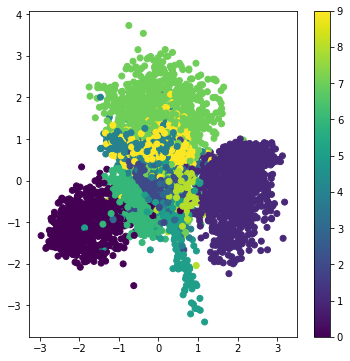

In [ ]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=100)
x_test_encoded = np.array(x_test_encoded)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2][:, 0], x_test_encoded[2][:, 1], c=y_test)
plt.colorbar()
plt.show()


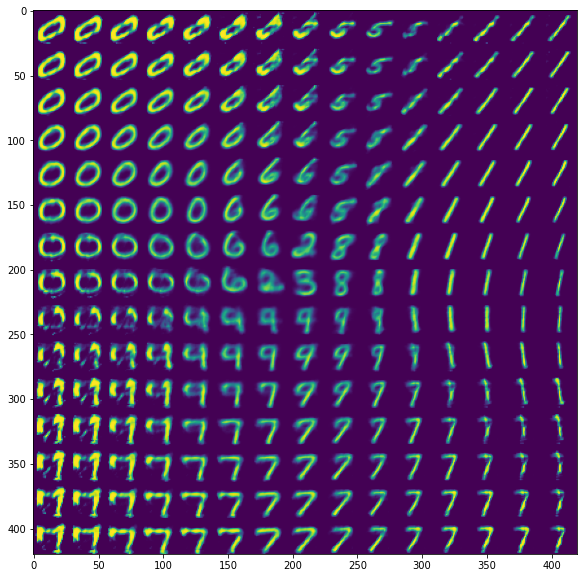

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-3, 3, n) # 从上面的分布图可以看到主要区域在 （-3，3）
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()